In [1]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import datetime
import csv
import os
from sklearn.metrics import r2_score, mean_squared_error
pd.options.display.max_rows = 99

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from modules.prediction import load_all_data
from modules.prediction import precrime_train_test_split
from modules.prediction import load_splits
from modules.prediction import create_all_splits
from modules.prediction import sample_model
from modules.poly_ridge import poly_ridge_model
from modules.fancy_time_series import fancy_time_series_model
from modules.eval_model import eval_predictions


In [3]:
crime_data = load_all_data()

/Users/jsamet/anaconda2/envs/py3k/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
from modules.prediction import create_test_period

In [5]:
split_all_2017 = create_test_period(datetime.date(2017,1,1),datetime.date(2017,10,1))

In [6]:
train_test_data = create_all_splits(crime_data, {'all_2017': split_all_2017})

In [7]:
X_train_2017, X_test_2017, y_train_2017, y_test_2017 = train_test_data['all_2017']

In [8]:
y_poly_2017 = poly_ridge_model(X_train_2017, y_train_2017, X_test_2017)
y_ts_2017 = fancy_time_series_model(X_train_2017, y_train_2017, X_test_2017, y_test_2017)
y_hybrid_2017 = (y_poly_2017 + y_ts_2017) / 2

In [9]:
offense_types = y_test_2017.select_dtypes(exclude=['object']).columns

In [10]:
results_and_predictions = pd.merge(
    y_test_2017[offense_types],
    y_hybrid_2017[offense_types],
    left_index=True,
    right_index=True,
    suffixes=['','_Predicted']
)
results_and_predictions_list = np.concatenate([
    results_and_predictions[[o, '{}_Predicted'.format(o)]].values
    for o in offense_types
])

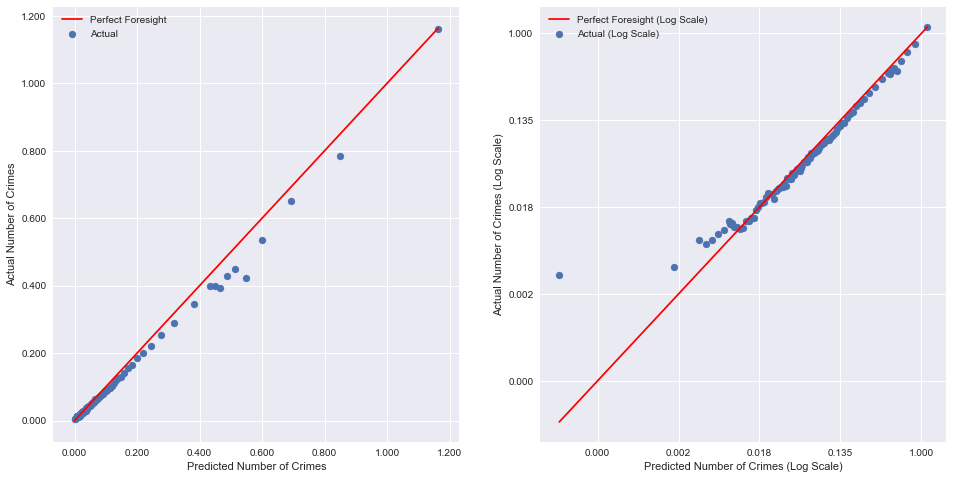

In [11]:
percentiles = [x for x in range(20,99,1)] + [x for x in np.arange(99.,100.,0.1)]

bands = [0,0.001] + [x for x in np.percentile(results_and_predictions_list[:,1], percentiles)] + [10]

grouped = np.stack([
    np.mean(results_and_predictions_list[((
        results_and_predictions_list[:,1] >= bands[i]
    ) & (
        results_and_predictions_list[:,1] < bands[i+1]
    ))], axis=0)
    for i in range(len(bands)-1)
])

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(grouped[:,1], grouped[:,0], label='Actual')
axes[0].plot(grouped[:,1], grouped[:,1], c='r', label='Perfect Foresight')
axes[0].set_xticklabels(['{0:.3f}'.format(x) for x in axes[0].get_xticks()])
axes[0].set_yticklabels(['{0:.3f}'.format(y) for y in axes[0].get_yticks()])
axes[0].set_xlabel('Predicted Number of Crimes')
axes[0].set_ylabel('Actual Number of Crimes')
axes[0].legend()

axes[1].scatter(np.log(grouped[:,1]), np.log(grouped[:,0]), label='Actual (Log Scale)')
axes[1].plot(np.log(grouped[:,1]), np.log(grouped[:,1]), c='r', label='Perfect Foresight (Log Scale)')
axes[1].set_xticklabels(['{0:.3f}'.format(np.exp(x)) for x in axes[1].get_xticks()])
axes[1].set_yticklabels(['{0:.3f}'.format(np.exp(y)) for y in axes[1].get_yticks()])
axes[1].set_xlabel('Predicted Number of Crimes (Log Scale)')
axes[1].set_ylabel('Actual Number of Crimes (Log Scale)')
axes[1].legend()
plt.show()

In [12]:
fig.savefig('../FinalHistogram.png')

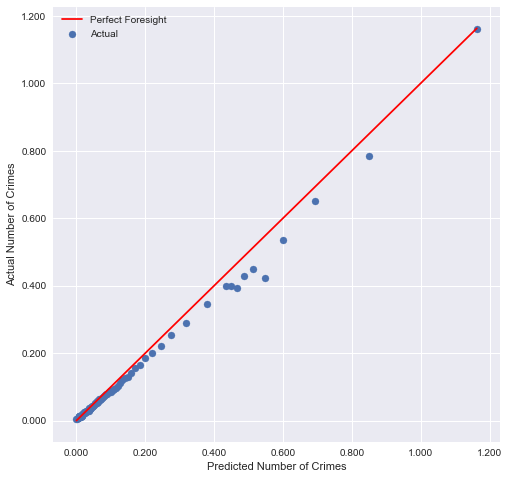

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(grouped[:,1], grouped[:,0], label='Actual')
ax.plot(grouped[:,1], grouped[:,1], c='r', label='Perfect Foresight')
ax.set_xticklabels(['{0:.3f}'.format(x) for x in ax.get_xticks()])
ax.set_yticklabels(['{0:.3f}'.format(y) for y in ax.get_yticks()])
ax.set_xlabel('Predicted Number of Crimes')
ax.set_ylabel('Actual Number of Crimes')
ax.legend()
fig.savefig('../FinalHistogramRegularScale.png')

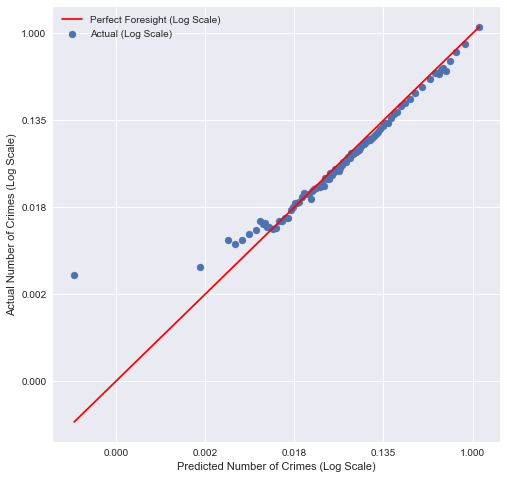

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(np.log(grouped[:,1]), np.log(grouped[:,0]), label='Actual (Log Scale)')
ax.plot(np.log(grouped[:,1]), np.log(grouped[:,1]), c='r', label='Perfect Foresight (Log Scale)')
ax.set_xticklabels(['{0:.3f}'.format(np.exp(x)) for x in ax.get_xticks()])
ax.set_yticklabels(['{0:.3f}'.format(np.exp(y)) for y in ax.get_yticks()])
ax.set_xlabel('Predicted Number of Crimes (Log Scale)')
ax.set_ylabel('Actual Number of Crimes (Log Scale)')
ax.legend()
fig.savefig('../FinalHistogramLogScale.png')